# Prey Predator Lab Notebook

(to edit this notebook and the associated python files, `git checkout` the corresponding commit by its hash, eg. `git checkout 422024d`)

In [1]:
from IPython.display import display, Markdown
from datetime import datetime
cur_datetime = datetime.now()
display(Markdown(f'# {cur_datetime.strftime("%d/%b/%Y %H:%M")}'))

# 11/Mar/2020 17:30

# Prey Predator dynamics on SD and ABM

On this notebook, we'll explore and visualize how P&P behave both in an dynamic system formalism, as in an agent-based one. Both models were written on cadCAD - an library for Complex Adaptive Dynamics simulations which allows you to mix and prototype different modelling paradigms in an reproducible and consistent manner.

In [2]:
%%capture
%matplotlib inline

# Dependences
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Experiments
import run

In [3]:
# Run all experiments. Typical run duration for an Core-i3 laptop is about 2-3min.
# Tweak the prey_predator_abm/sim_params.py file if you want it to take longer (or not).
start_time = time()
experiments = run.run()
end_time = time()
print("Execution in {:.1f}s".format(end_time - start_time))


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x7f9648ed7510>, <cadCAD.configuration.Configuration object at 0x7f9648ed7150>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f9648ed7510>, <cadCAD.configuration.Configuration object at 0x7f9648ed7150>]
Execution in 71.4s


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


### Dynamical System: Lotka-Volterra

This is the standard introductory model for Prey-Predator interactions and dynamical systems in general. It is based on the following equations:

\begin{aligned}{\frac {d}{dt}Prey}&=\alpha * Prey-\beta * Prey * Predators,\\{\frac {d}{dt}Predators}&=\delta * Prey * Predators-\gamma * Predators,\end{aligned}

Where $\alpha$ and $\gamma$  are the prey growth rate and predator elimination rate, and $\delta$ and $\gamma$ are interaction factors between preys and predators.

The most promenient feature of it is the existence, depending on the choice of parameters, of an repeteable cycle around an fixed point which creates an dynamical equilibrium between the number of preys and predators on an system.

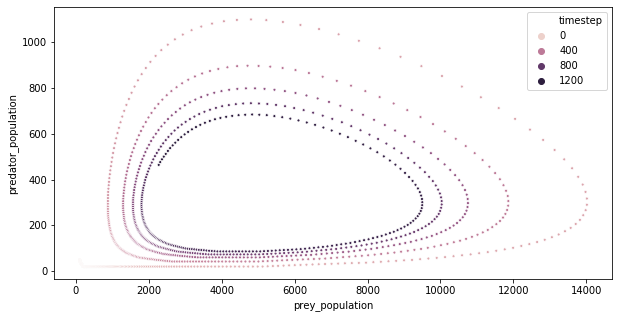

In [4]:
plt.figure(figsize=(10, 5))
sns.scatterplot(data=experiments.dataset[0],
                x='prey_population',
                y='predator_population',
                hue='timestep',
                marker='.')
plt.show()

## Agent-based modelling

There are a lot of possible ABMs for any given phenomenon. The beauty of cadCAD is that it'll allow you to put, modify and remove simulation blocks and steps at will. 

For this demo, we'll adopt an model based on an grid world, on which preys and predators do the following steps on each phase of their discrete and numerical lifes:

1. (before anything) Food is grown on every site.
2. All agents digests some of the food on their stomach and olden themselves.
3. All agents move or not to an available random neighboring location.
4. The agents reproduce themselves if there is an available partner nearby
5. The prey agents feed on the available food
6. The predator agents hunts the nearby preys
7. All old enough agents die

There is an inherent stochastic nature on this model, and every time that you run it, we'll have an completely different simulation for the same parameters. But we can see that there is sort of an random equilibrium that converges to the dynamical equilibrium which we presented on the dynamical simulation.

There is an bonus that ABMs can contain an very dense set of informations to which analyse. We'll plot only the most obvious ones, but the world is yours if you want to trace the network relations between the agents, or the geospatial statistics around the ABM.

In [5]:
# Get the ABM results
agent_ds = experiments.dataset[1].agents
site_ds = experiments.dataset[1].sites
timesteps = experiments.dataset[1].timestep

In [6]:
# Get metrics

## Agent quantity
prey_count = agent_ds.map(lambda s: sum([1 for agent in s.values() if agent['type'] == 'prey']))
predator_count = agent_ds.map(lambda s: sum([1 for agent in s.values() if agent['type'] == 'predator']))


## Food quantity
food_at_sites = site_ds.map(lambda s: s.sum())
food_at_prey = agent_ds.map(lambda s: sum([agent['food'] 
                                           for agent 
                                           in s.values() if agent['type'] == 'prey']))
food_at_predators = agent_ds.map(lambda s: sum([agent['food'] 
                                                for agent in s.values() 
                                                if agent['type'] == 'predator']))

## Food metrics
median_site_food = site_ds.map(lambda s: np.median(s)) 
median_prey_food = agent_ds.map(lambda s: np.median([agent['food'] 
                                                     for agent in s.values() 
                                                     if agent['type'] == 'prey']))
median_predator_food = agent_ds.map(lambda s: np.median([agent['food'] 
                                                         for agent in s.values() 
                                                         if agent['type'] == 'predator']))

## Age metrics
prey_median_age = agent_ds.map(lambda s: np.median([agent['age'] for agent in s.values() if agent['type'] == 'prey']))
predator_median_age = agent_ds.map(lambda s: np.median([agent['age'] for agent in s.values() if agent['type'] == 'predator']))

# Create an analysis dataset
data = (pd.DataFrame({'timestep': timesteps,
                      'prey_count': prey_count,
                      'predator_count': predator_count,
                      'food_at_sites': food_at_sites,
                      'food_at_prey': food_at_prey,
                      'food_at_predators': food_at_predators,
                      'median_site_food': median_site_food,
                      'median_prey_food': median_prey_food,
                      'median_predator_food': median_predator_food,
                      'prey_median_age': prey_median_age,
                      'predator_median_age': predator_median_age})       
       )

### An temporal summary for the simulation

On the following plot, we can see how the prey, predator and available food changes along time. Can you see any cyclical patterns?

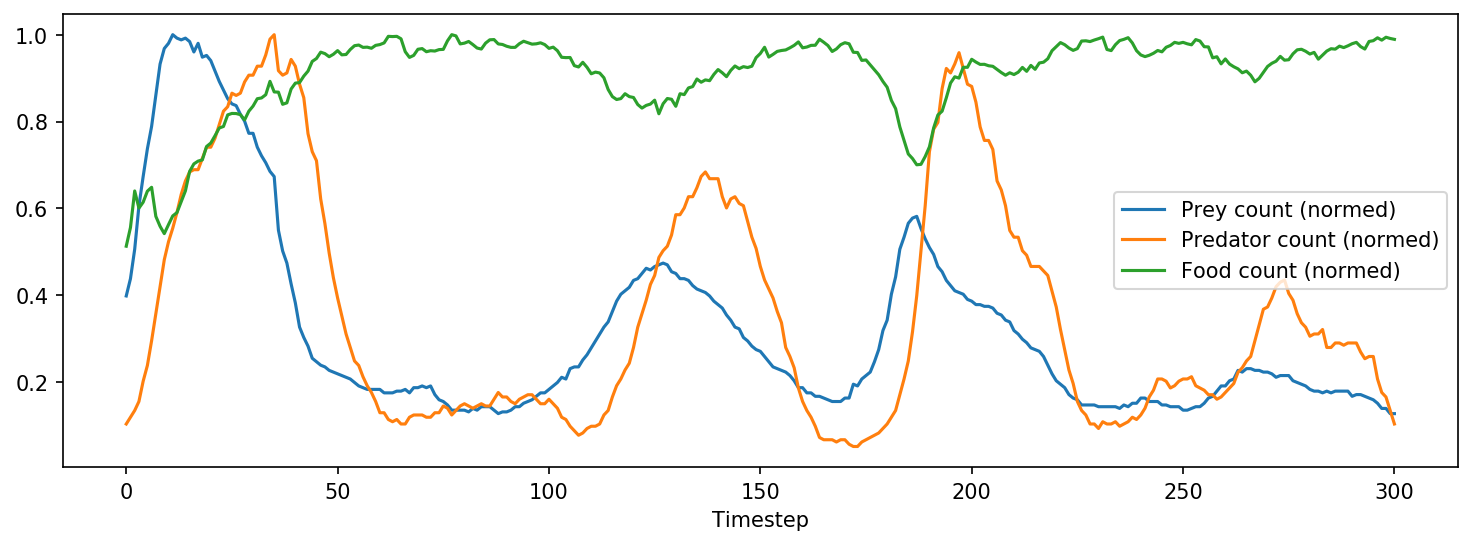

In [7]:
plt.figure(figsize=(12, 4), dpi=150)
plt.plot(timesteps,
         prey_count / prey_count.max(),
         '-',
         color='C0',
         label='Prey count (normed)')
plt.plot(timesteps,
         predator_count / predator_count.max(),
         '-',
         color='C1',
         label='Predator count (normed)')
plt.plot(timesteps,
         food_at_sites / food_at_sites.max(),
         '-',
         color='C2', 
         label='Food count (normed)')
plt.xlabel('Timestep')
plt.legend()
plt.show()

### Prey predator phase space

Note that it sorts of converges, in an chaotic manner, to the dynamical system model

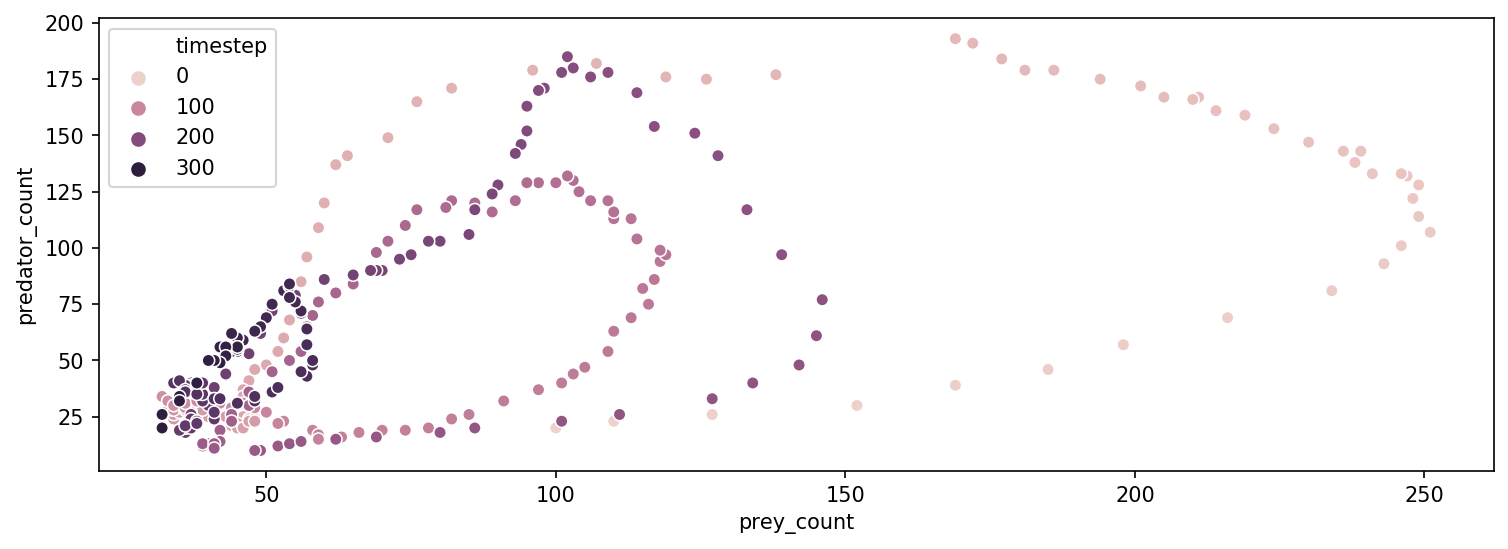

In [8]:
plt.figure(figsize=(12, 4), dpi=150)
sns.scatterplot(data=data,
                x='prey_count',
                y='predator_count',
                hue='timestep')
plt.show()

### Prey prevalence vs food availability on the world

There is an inverse relation between the available world food, and the number of prey.

Why there is an increasing variance when the number of prey is larger?

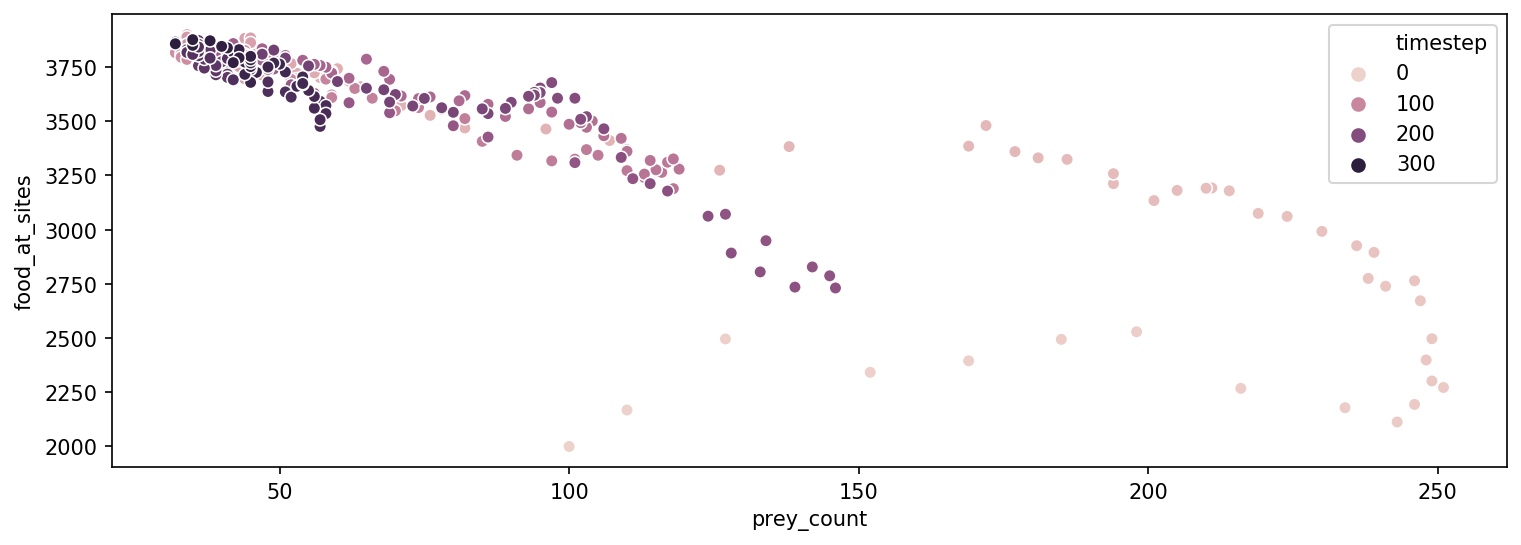

In [9]:
plt.figure(figsize=(12, 4), dpi=150)
sns.scatterplot(data=data,
                x='prey_count',
                y='food_at_sites',
                hue='timestep')
plt.show()

#### Food inside agents stomachs

In median, the prey stomachs are always sort of full, while the predators stomach has an spectrum between hunger and fullness.

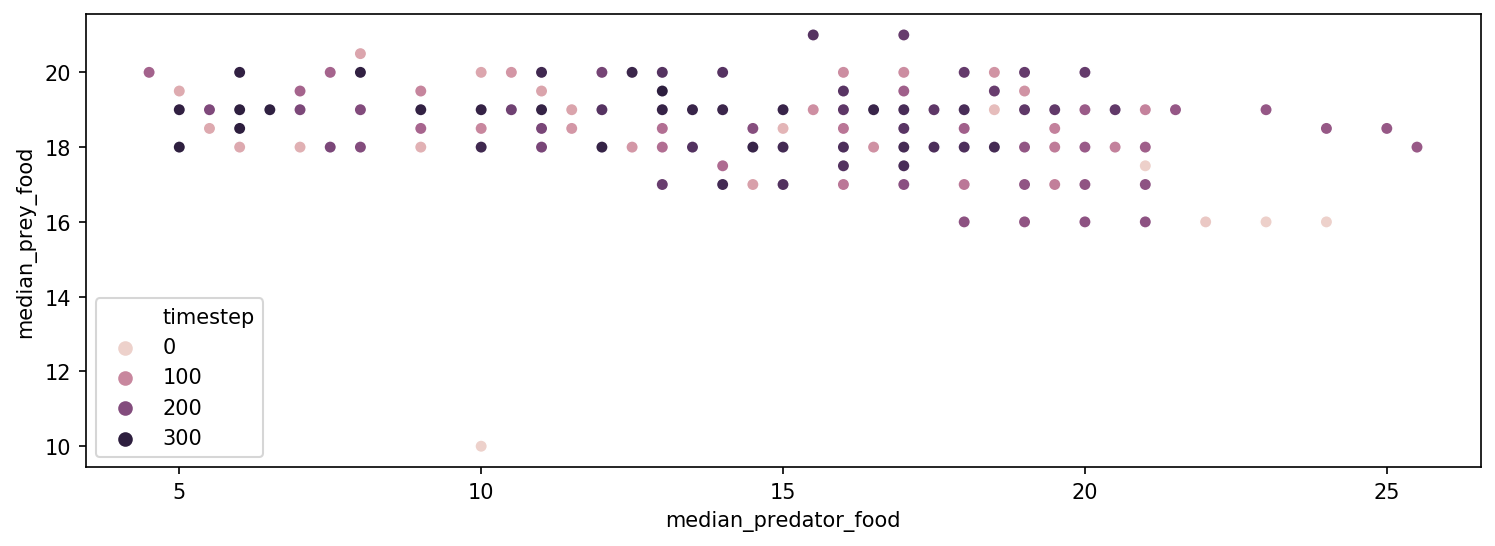

In [10]:
plt.figure(figsize=(12, 4), dpi=150)
sns.scatterplot(data=data,
                x='median_predator_food',
                y='median_prey_food',
                hue='timestep')
plt.show()

### Brute force plotting

There are a lot of patterns to explore and extract knowlodge. On the following plot, you can see all pairwise variable comparisons. Can you notice anything interesting to investigate it further?

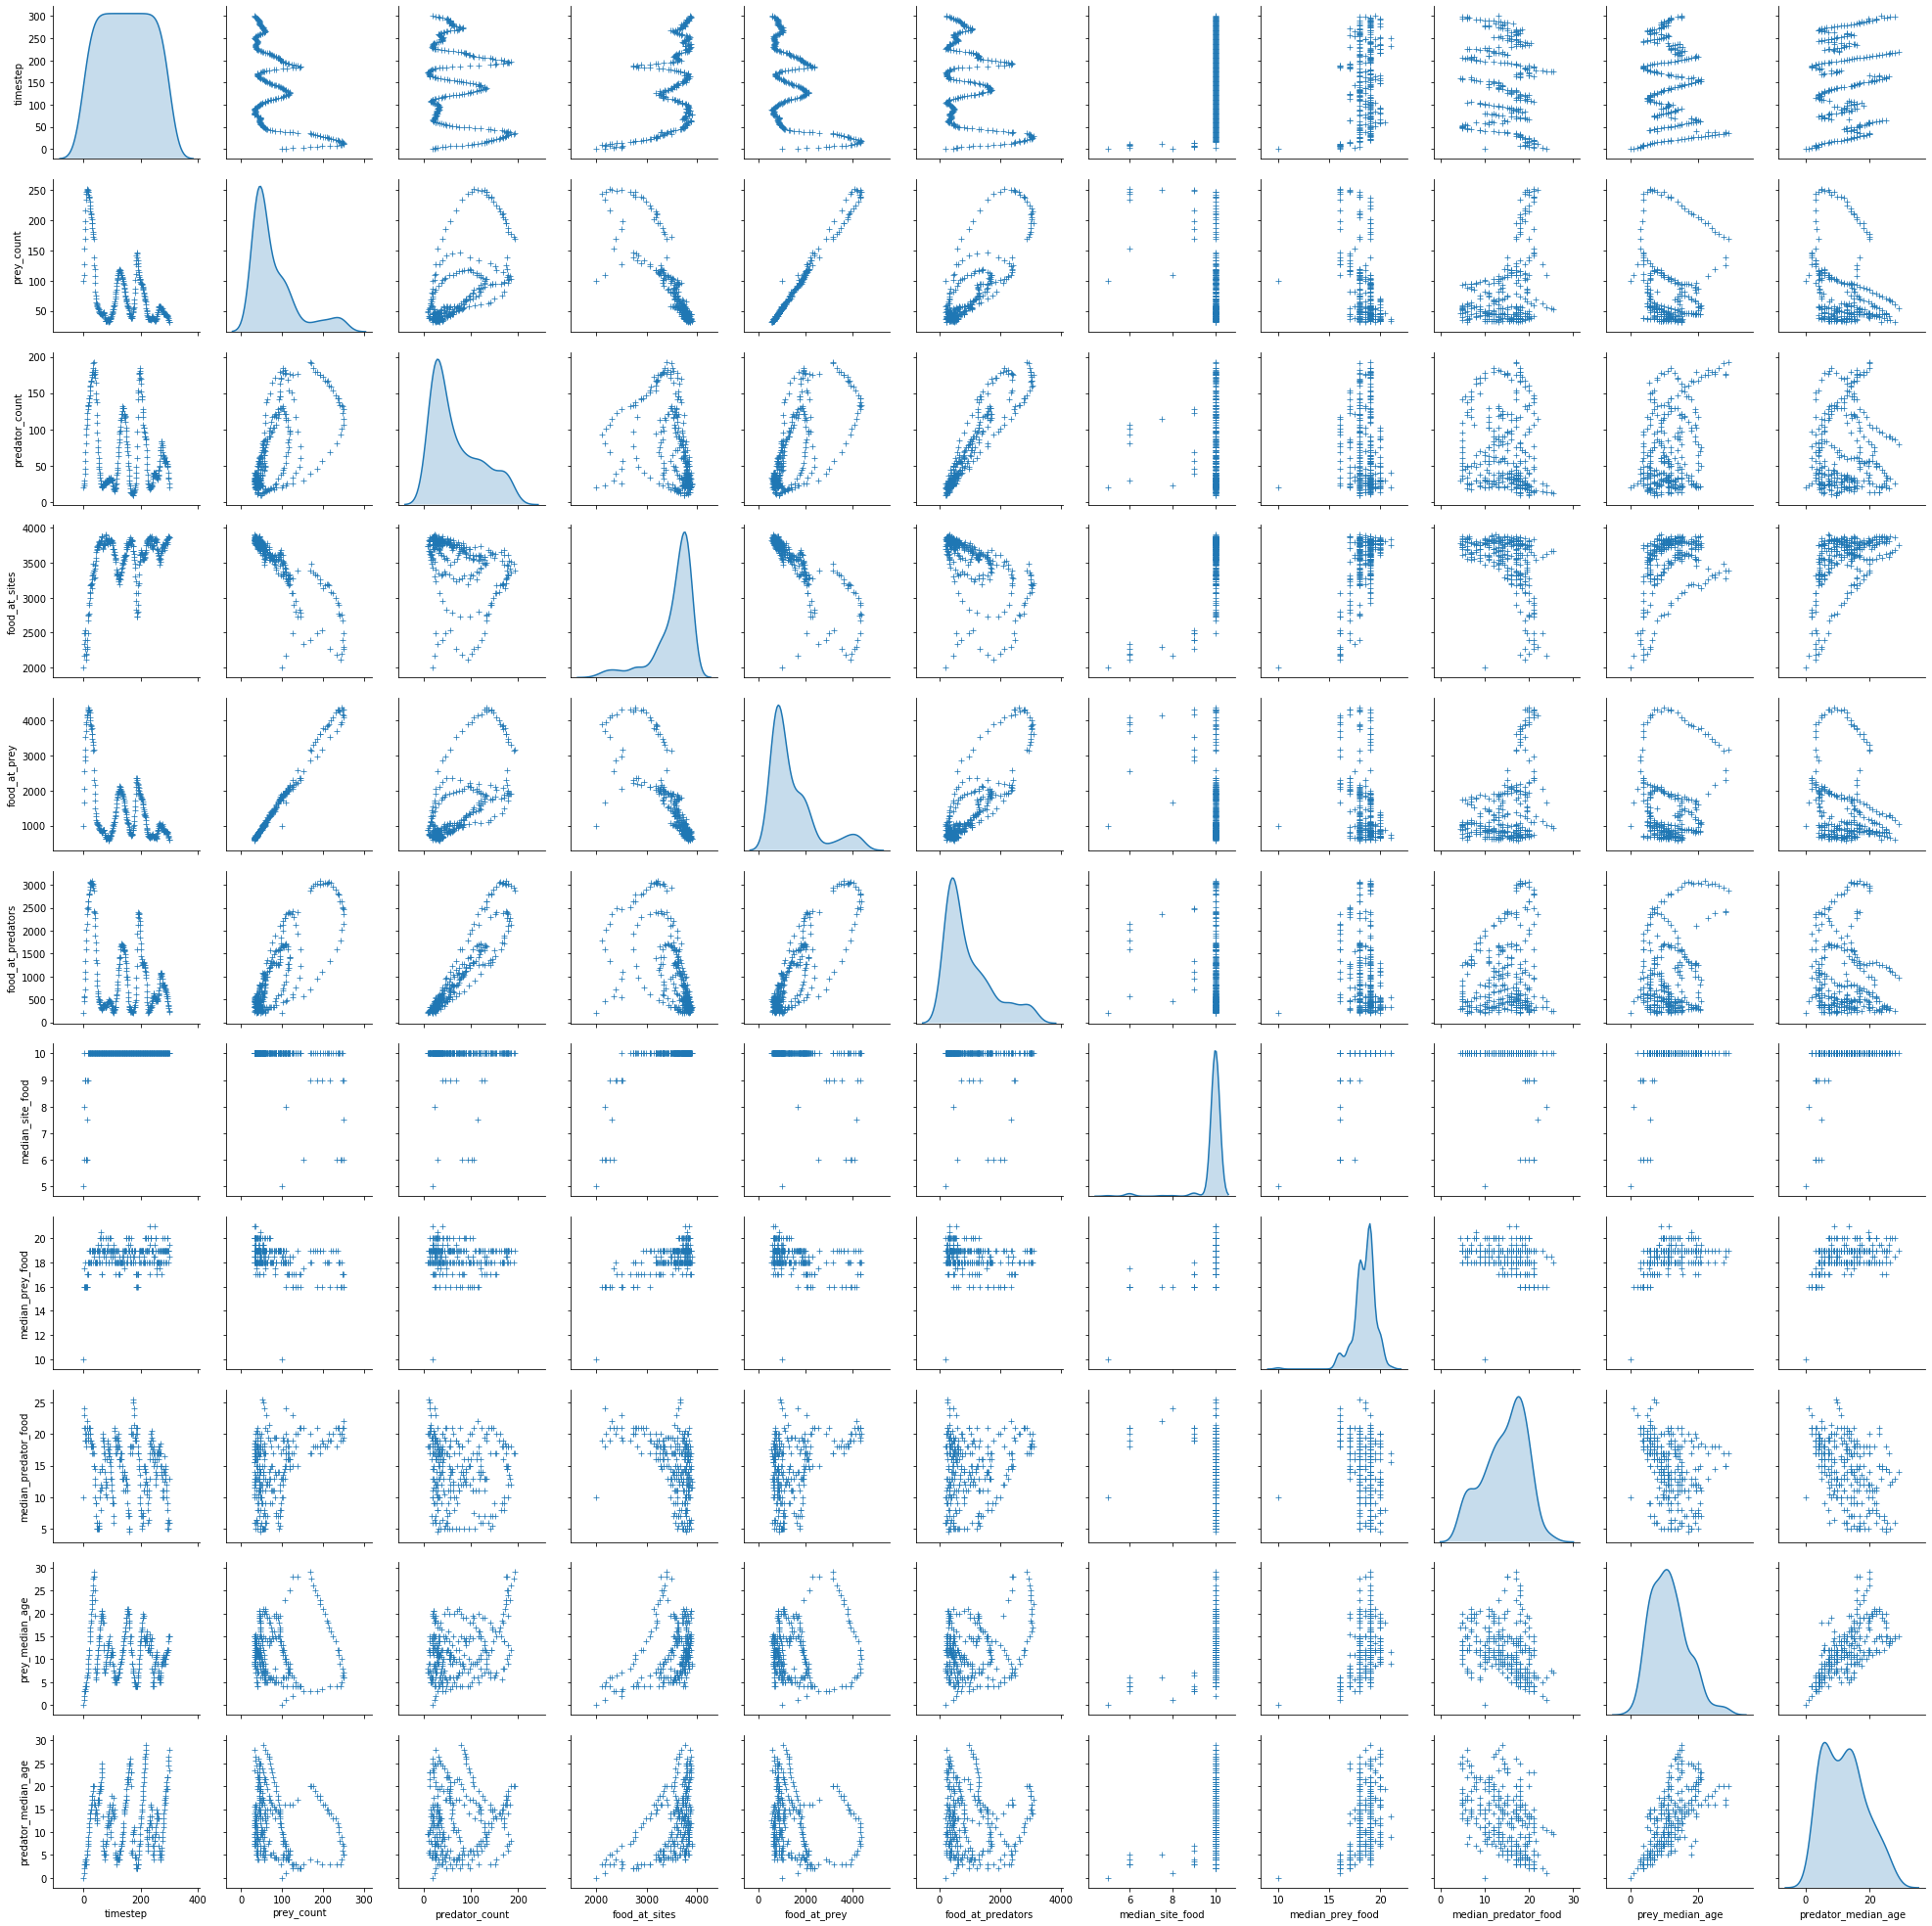

In [11]:
sns.pairplot(data=data, 
             diag_kind='kde', 
             markers='+')
plt.show()

### Conclusions and final words

We explored here two different paradigms for modelling: the dynamic system one, which captures an macroscopical view of the system, and the agent-based one, which uses an microscopic view for the system. Depending on the targets and considerations, both can be equivalent or completely distinct, but can be also complementary. cadCAD allows you to mix them at will, so you can have hybrid models where agent behaviour and environment are shaped by complex dynamical systems. There is an whole multiverse of mixed simulations that you can do (challenges on next block for you to try!).

Obviously, both paradigms have some characteristics, which in general manner we can express as being:

#### Dynamical system (macroscopic view) advantages

* Fast-performing, allowing an very large number of timesteps and simulations
* Easier to prototype and to add/modify mechanisms
* Easier to insert a multitude of complex factors
* The output is usually easy to visualize
* Inner workings are more transparent

#### Agent-based modelling (microscopic view) advantages

* Are conceptually closer to experience, making easier to explain
* There is more allowance on stochastic mechanisms and logic
* Easier to generate complex behaviour with simple rules
* Generates more granular and detailed information
* Inner workings have more depth


### Proposed challenges

#### Sazonability of food growth

An quick way to mix the ABM and SD paradigms is by the following: what if the food growth depends on an dynamical system? 

You can model that by modifying the food growth policy, like by inserting an sazonability which depends on the timestep for example. Or you could go even further and try to express it as depending on an irradiance-based dynamical system which models the Sun position according to Earth's movements (rotation, translation, recession and nutation). How much do you think that those layers of additional complexity will add to knowledge behind the physical system which we are modelling?

#### Stochasticity of the agents decisions

When the agents takes its actions (move, reproduce and eat), there is an randomness about where they'll do it, but not about if they actually decide to do it. What if the decision was random instead of always doing it? What if this decision depends on an given probability distribution? And what if the decision was shaped by the nearby enviroment, like predator presence and food availability nearby?

#### Agent death by exponential probability

All agents die when the maximum lifespan arrives. Can you modify the ABM for having an associated spontaneous death probability according to exponential distribution? Something which makes almost all young agents live, but most old ones to die? What if this probability is shaped somehow to the agent health, like the fullness/emptiness of his stomach?

#### Prey evolution & adaptation

This is the master challenge.  What if the preys had individually variable attributes which could bring them competitive advantages? Like movement speed, reproduction rate, or different lifespans? What if those attributes were mutated and passed on their offspring?

This is the Darwinian version of the P&P ABM. **Are you the fittest of the cadCAD modellers?**